# Replay buffer for MNIST classification

In [1]:
import os
import jax
import optax
import dynamax
import numpy as np
import pandas as pd
import jax.numpy as jnp
import flax.linen as nn

import seaborn as sns
import matplotlib.pyplot as plt
from dynamax.utils import datasets
from itertools import product
from functools import partial
from tqdm.notebook import tqdm
from typing import Callable, Tuple
from flax.training.train_state import TrainState

In [2]:
from rebayes import batch_sgd as bsgd

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
%config InlineBackend.figure_format = "retina"

# (Sorted) rotated MNIST

In [5]:
num_train = 1000
train, test = datasets.load_mnist()

X, y = train
X_test, y_test = test

X = jnp.array(X)[:1000].reshape(-1, 28 ** 2)
y = jnp.array(y)[:1000]
y_ohe = jax.nn.one_hot(y, 10)

X_test = jnp.array(X_test).reshape(-1, 28 ** 2)
y_test = jnp.array(y_test)
y_ohe_test = jax.nn.one_hot(y_test, 10)

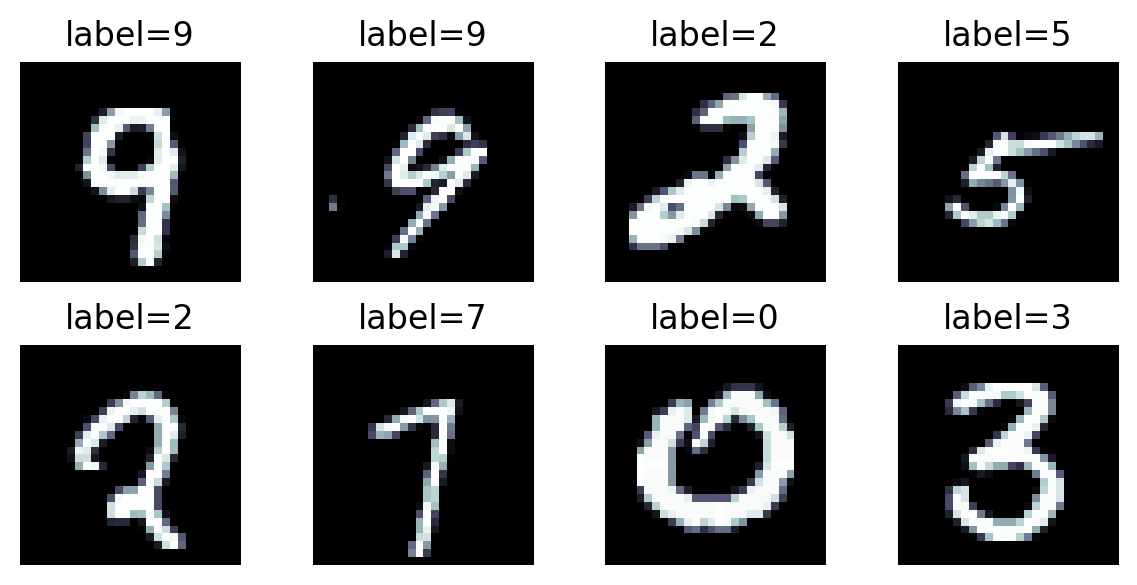

In [6]:
np.random.seed(314)
n_test = 8
ixs_test = np.random.randint(0, len(X), size=n_test)

fig, axs = plt.subplots(2, 4, figsize=(6, 3))
axs = axs.ravel()
for ax, ix in zip(axs, ixs_test):
    img = X[ix]
    label = y[ix]
    ax.imshow(img.reshape(28, 28), cmap="bone")
    ax.axis("off")
    ax.set_title(f"{label=:0.0f}")
plt.tight_layout()

# Training

## Setup

In [7]:
class MLP(nn.Module):
    n_out: int
    activation: Callable = nn.relu
    
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(100)(x)
        x = self.activation(x)
        x = nn.Dense(100)(x)
        x = self.activation(x)
        x = nn.Dense(50)(x)
        x = self.activation(x)
        x = nn.Dense(10)(x)
        x = self.activation(x)
        x = nn.Dense(self.n_out)(x)
        return x

In [8]:
key = jax.random.PRNGKey(314)
key_init, key_train = jax.random.split(key)

## Vanilla SGD

In [9]:
@partial(jax.jit, static_argnames=("applyfn",))
def lossfn(params, X, y, applyfn):
    logits = applyfn(params, X)
    probs = jax.nn.softmax(logits)
    
    nll = -y * jnp.log(probs)
    return nll.sum(axis=-1).mean()


@partial(jax.jit, static_argnames=("applyfn",))
def metric(params, X, y, applyfn):
    yhat = applyfn(params, X).squeeze().argmax(axis=-1)
    acc = (y == yhat).mean()
    return acc

In [10]:
%%time

num_epochs = 10_000
batch_size = 1000

model = MLP(10, activation=nn.elu)
batch_init = jnp.ones((10, 28 ** 2))
params_init = model.init(key_init, batch_init)

state = TrainState.create(
    apply_fn=model.apply,
    params=params_init,
    tx=optax.adam(5e-6)
)


state, losses = bsgd.train_full(
    key_init, num_epochs, batch_size, state, X, y_ohe, lossfn,
    X_test, y_ohe_test
)
losses = jax.block_until_ready(losses)

CPU times: user 7.75 s, sys: 26.5 ms, total: 7.78 s
Wall time: 9.47 s


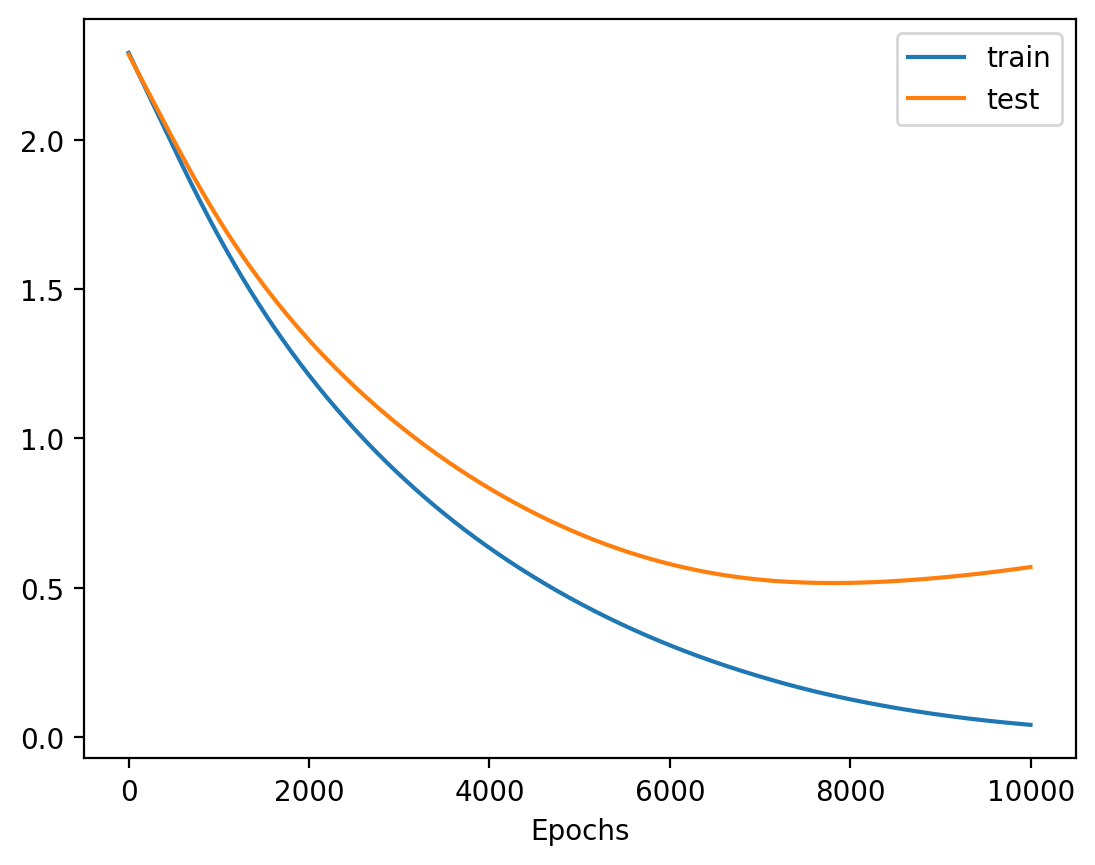

In [11]:
plt.plot(losses["train"], label="train")
plt.plot(losses["test"], label="test")
plt.legend()
plt.xlabel("Epochs");

In [12]:
sgd_loss = metric(state.params, X_test, y_test, state.apply_fn).item()
sgd_loss

0.843999981880188

# Replay buffer FIFO

Consider a buffer with size 4, the minibatches are given by
```
[x0,]
[x0, x1]
[x0, x1, x2]
[x0, x1, x2, x3]
[x1, x2, x3, x4]
[x2, x3, x4, x5]
...
```

In [13]:
@partial(jax.jit, static_argnames=("applyfn",))
def lossfn_fifo(params, X, y, ixs, applyfn):
    X_batch, y_batch = X[ixs], y[ixs]
    counter = (ixs >= 0)
    
    yhat = applyfn(params, X_batch).ravel()
    loss = (y_batch - yhat) ** 2
    loss = (loss * counter).sum() / counter.sum()
    return loss


@partial(jax.jit, static_argnames=("applyfn",))
def lossfn_fifo(params, X, y, ixs, applyfn):
    X_batch, y_batch = X[ixs], y[ixs]
    counter = (ixs >= 0)
    
    logits = applyfn(params, X_batch)
    probs = jax.nn.softmax(logits)
    
    nll = -y_batch * jnp.log(probs)
    nll = nll.sum(axis=-1)
    loss = (nll * counter).sum() / counter.sum()
    
    return loss

In [14]:
%%time

buffer_size = 100
n_inner = 1

state_init = TrainState.create(
    apply_fn=model.apply,
    params=params_init,
    tx=optax.adam(1e-4)
)

rebayes = bsgd.ReFifoSGD(buffer_size, lossfn_fifo, n_inner=n_inner)
state, losses = rebayes.scan(state_init, X, y_ohe, X_test, y_test, metric)

CPU times: user 4.27 s, sys: 0 ns, total: 4.27 s
Wall time: 2.16 s


In [15]:
yhat_test = rebayes.predict_obs(state, X_test)
acc_test = (yhat_test.argmax(axis=1) == y_test).mean()

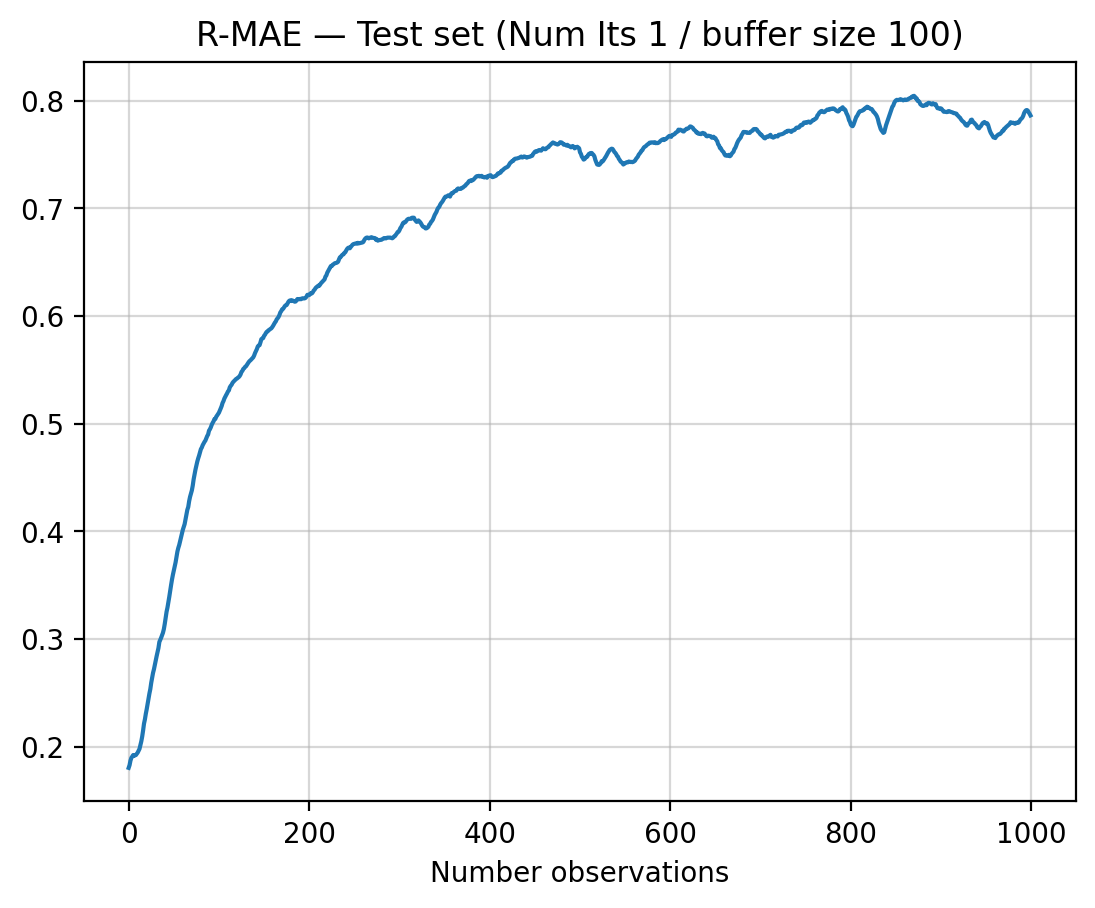

In [16]:
plt.plot(losses["test"])
plt.grid(alpha=0.5)
plt.xlabel("Number observations")
plt.title(f"R-MAE — Test set (Num Its {n_inner} / buffer size {buffer_size})");

In [17]:
%%time
@partial(jax.pmap, in_axes=0)
@partial(jax.vmap, in_axes=1)
def init_and_train(key):
    params_init = model.init(key, batch_init)
    state_init = TrainState.create(
        apply_fn=model.apply,
        params=params_init,
        tx=optax.adam(1e-4)
    )

    rebayes = bsgd.ReFifoSGD(buffer_size, lossfn_fifo, n_inner=n_inner)
    state, losses = rebayes.scan(state_init, X, y_ohe, X_test, y_test, metric)
    return state, losses
    

n_samples = 8 * 5
keys = jax.random.split(key, n_samples).reshape(8, 2, -1)
states, losses = init_and_train(keys)

CPU times: user 16.4 s, sys: 415 ms, total: 16.8 s
Wall time: 8.99 s


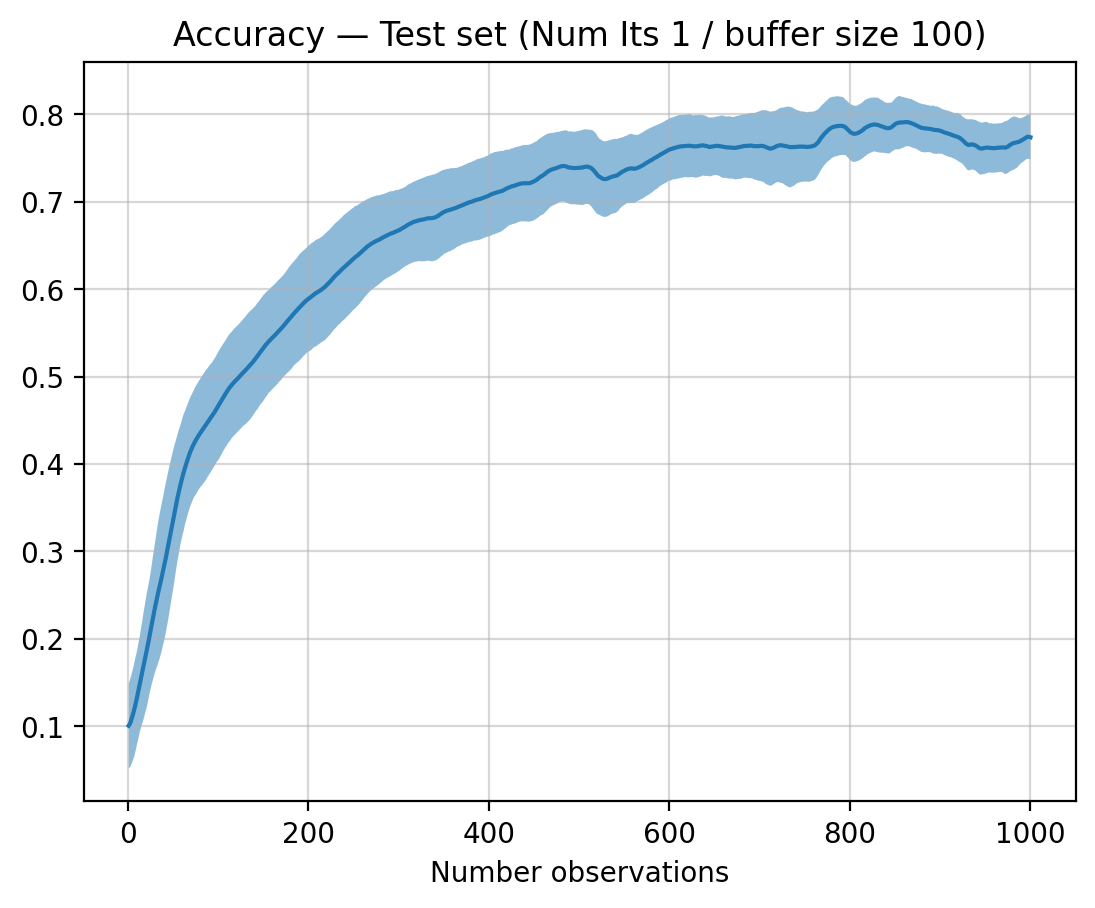

In [18]:
xrange = jnp.ones_like(y).cumsum()
mean_loss = losses["test"].mean(axis=(0, 1))
std_loss = losses["test"].std(axis=(0, 1))
plt.plot(xrange, mean_loss)
plt.fill_between(xrange, mean_loss - 2 * std_loss, mean_loss + 2 * std_loss, alpha=0.5)
plt.grid(alpha=0.5)
plt.xlabel("Number observations")
plt.title(f"Accuracy — Test set (Num Its {n_inner} / buffer size {buffer_size})");

### Multiple buffer sizes

In [19]:
buffer_size_list = [1, 5, 10, 20, 50, 100, 200, 500]
n_buffers = len(buffer_size_list)

n_inner = 2

test_losses = {}
for buffer_size in tqdm(buffer_size_list):
    rebayes = bsgd.ReFifoSGD(buffer_size, lossfn_fifo, n_inner=n_inner)
    state, losses = rebayes.scan(state_init, X, y_ohe, X_test, y_test, metric)
    test_losses[buffer_size] = losses["test"]

  0%|          | 0/8 [00:00<?, ?it/s]

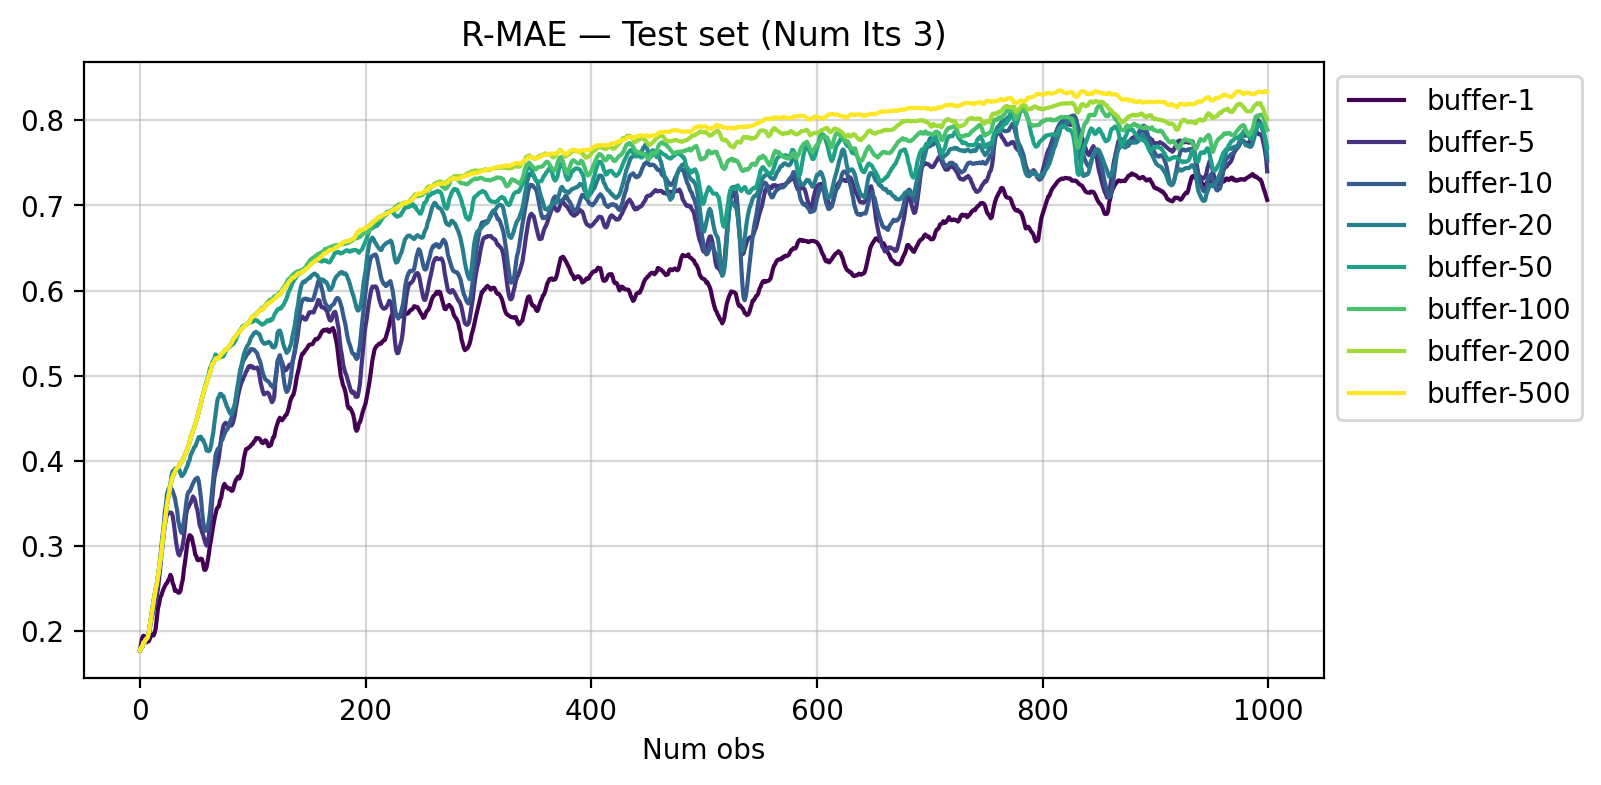

In [20]:
fig, ax = plt.subplots(figsize=(8, 4))
n_inner = 3
colors = plt.cm.viridis(np.linspace(0, 1, n_buffers))

for c, buffer_size in zip(colors, buffer_size_list):
    loss_test = test_losses[buffer_size]
    plt.plot(loss_test, c=c, label=f"buffer-{buffer_size}")
    
plt.xlabel("Num obs")
plt.title(f"R-MAE — Test set (Num Its {n_inner})")
# plt.axhline(y=sgd_loss, c="tab:gray", linestyle="--", label="SGD minibatch")
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.grid(alpha=0.5)

In [23]:
%%time
n_inner_list = [1, 2, 3, 4, 5, 10]
buffer_size_list = [1, 5, 10, 15, 20, 25, 50, 100]
n_buffers = len(buffer_size_list)

df_summary = []
elements = list(product(n_inner_list, buffer_size_list))
pbar = tqdm(elements)
for (n_inner, buffer_size) in pbar:
    
    
    rebayes = bsgd.ReFifoSGD(buffer_size, lossfn_fifo, n_inner=n_inner)
    state, losses = rebayes.scan(state_init, X, y_ohe, X_test, y_test, metric)
    test_loss = losses["test"][-1]
    entry = {
        "n_inner": n_inner,
        "buffer_size": buffer_size,
        "metric": test_loss
    }
    df_summary.append(entry)
df_summary = pd.DataFrame(df_summary)

  0%|          | 0/48 [00:00<?, ?it/s]

CPU times: user 3min 43s, sys: 3.54 s, total: 3min 47s
Wall time: 2min 4s


Text(0.5, 1.0, 'R-MAE — Test set')

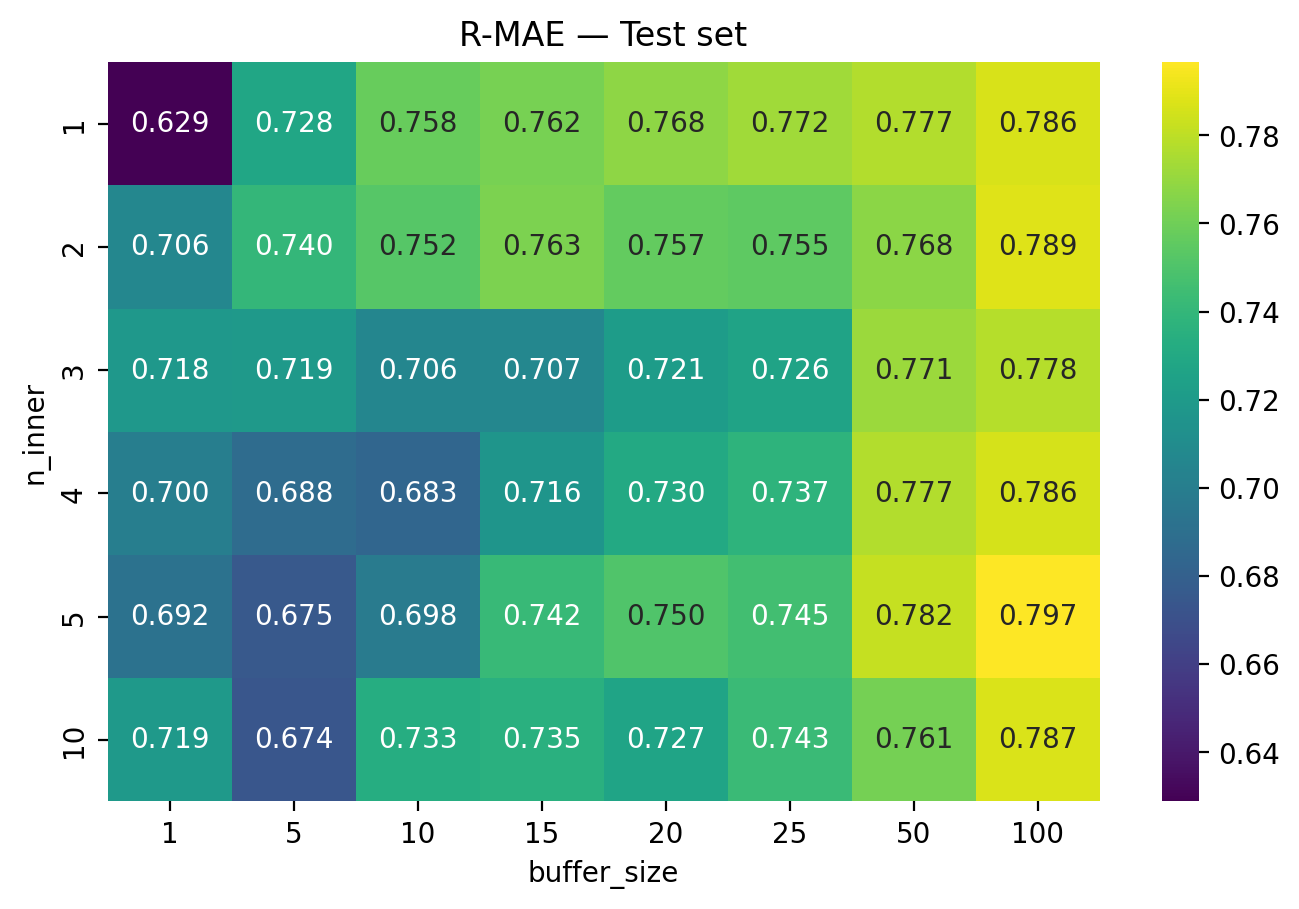

In [27]:
group = df_summary.pivot_table(index="n_inner", columns="buffer_size", values="metric")
fig, ax = plt.subplots(figsize=(8, 4.8))
sns.heatmap(group, cmap="viridis", annot=True, fmt="0.3f", ax=ax)
plt.title("R-MAE — Test set")